<h2> TO DO LIST </h2> 

- Auto determine column with cost / clicks 
- Add a proper UI interface - requires server integration
- Correllogram - between pairs (like family matters)
- Add option to add budget and then showcase opportunity per bucket
- ngram_range parameter to tfidf vectorizer 
- tqdm progress bar


<h2> DONE </h2>

- Wordcloud graph 
- Add errors (e.g. wrong filename) 
- Fix error of metric with a comma 
- Remove ASCII characters 
- handle inputs with more than 2 columns (at least no error)
- categorize one category per keyword
- return initial metric given in the output as well



In [7]:
#change to the name of the input file you uploaded
name_of_file_uploaded = 'example_fake_csv.csv' #@param {type:"string"}

In [8]:
#define estimation of number of categories we will try to achieve, ideally between 7-15
requested_number_of_categories = 6 #@param {type:"slider", min:5, max:20, step:1}

In [9]:
#pip install --user -U nltk
#nltk.download('punkt')

In [10]:
#import packages 
import pandas as pd 
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#avoid messages on screen
from contextlib import redirect_stdout
import os
with redirect_stdout(open(os.devnull, "w")):
    nltk.download('stopwords')
    nltk.download('punkt')

# nltk.download('stopwords')
# nltk.download('punkt')

from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
#read from Google Drive directly
#data = pd.read_csv('/content/drive/MyDrive/test_data.csv')



In [11]:
print (name_of_file_uploaded)

#test123 = pd.read_csv('./fiverrbucket3.csv')

#print (test123)

example_fake_csv.csv


In [12]:
#read from Google Drive directly
#data = pd.read_csv('/content/drive/MyDrive/test_data.csv')
import sys

try:
    data = pd.read_csv('./{}'.format(name_of_file_uploaded))
    # data = pd.read_csv('./test_data.csv')

except:
  try:
    data = pd.read_excel('./{}'.format(name_of_file_uploaded))
  # data = pd.read_excel('./test_data.xlsx')
  except:
      try: 
        data = pd.read_csv('./{}'.format(name_of_file_uploaded),encoding='cp1252')
      except:
          try:
            data = pd.read_excel('./{}'.format(name_of_file_uploaded),encoding='cp1252')  
          except: 
            print ("There is an error with the input file, please make sure that you uploaded the file and entered its name correctly (case-sensitive)")
            sys.exit(1)


#print(len(data.columns))

#define variables for charts later
chart_title = 'Volume estimation by category'
chart_axis_tile ='Indexed Volume (1-100)'

#add 1 in case no metric column was given
if (len(data.columns) == 1):
  data['metric'] = 1
  chart_title = 'Frequency estimation by category'
  chart_axis_tile ='Indexed Frequency (1-100)'

#get columns names
names = list(data.columns.values.tolist()) 

#unify first two rows names
names[0] = "queries"
names[1] = "metric"
#print (names)
data.columns = names

#data.columns = ['queries','metric']

#data['metric'].dtype == 'O'



data['metric'].dtype

dtype('int64')

In [13]:
#validate data type of "queries column"
data['queries'] = data['queries'].map(lambda query: str(query) if isinstance(query, int) else query)


#validate data type of "metric column"
#remove special characters and non-numeric
if(data['metric'].dtype == 'O'):
  data['metric'] = data['metric'].map(lambda query: re.sub('\W+','', query).strip())
  data['metric'] = data['metric'].map(lambda query: re.sub('[^0-9]','', query).strip())
  data['metric'] = data['metric'].replace('', 1)

#print (data['metric'].dtype == 'O')


#change data type
data['metric'] = data['metric'].astype('float')
data['metric'] = data['metric'].replace([np.inf, -np.inf],1)
data['metric'] = data['metric'].fillna(1)

#remove aggregate total values
bad_queries = ['Aggregate Total','queries','aggregate total','total']
data = data[~data['queries'].isin(bad_queries)]


#remove non-ascii
#lambda x: True if x % 2 == 0 else False
data['queries'] = data['queries'].map(lambda query: query if isinstance(query, int) else str(query).encode("ascii", "ignore").decode().strip())
#data['queries'] = data['queries'].map(lambda query: query.encode("ascii", "ignore").decode().strip())

# #translate french letters
translationTable = str.maketrans("éàèùâêîôûç", "eaeuaeiouc")
data['queries'] = data['queries'].map(lambda query: query if isinstance(query, int) else query.translate(translationTable).strip())
# data['queries'] = data['queries'].map(lambda query: query.translate(translationTable).strip())


#normalize on a scale of 1-100
data['normalized_metric'] = (data.iloc[:,1] * 99 / max(data.iloc[:,1])).astype('int')+1
# print (data.head())
# print (data.info())
print (data[data['queries'] == 'Aggregate Total'])
print (len(data.queries))

Empty DataFrame
Columns: [queries, metric, Most specific brand, Clicks, Avg. CPC, normalized_metric]
Index: []
273


In [14]:
#remove special characters 
data['formatted_queries'] = data['queries'].map(lambda query: query if isinstance(query, int) else re.sub('\W+',' ', query).strip())
#print (data.head(10))
print (data['formatted_queries'].head(20))

0                          redhat ansible
1                             scan a code
2                      usps label printer
3                                   rhcsa
4                                    cspm
5                                   xcode
6                      github desktop app
7                          linux download
8                     google shopping ads
9                 merchant center account
10                         forrester wave
11                   usps shipping labels
12                openshift vs kubernetes
13                                dev ops
14                    shipping label usps
15                                 centos
16              www apple com move to ios
17    how to advertise on google shopping
18                         xcode download
19                          cnapp gartner
Name: formatted_queries, dtype: object


In [15]:
#create a copy to later merge with one_to_one 
data_copy = data.copy()

#change first columns of data_copy as well (for unification later on)
names_data_copy = list(data_copy.columns.values.tolist()) 
names_data_copy[0] = "Query"
data_copy.columns = names_data_copy

In [16]:
#remove stop words such as "the" or "in"
data['formatted_queries'] = data['formatted_queries'].map(lambda query: query if isinstance(query, int) else [word for word in word_tokenize(query) if not word in stopwords.words()])
#print (data.sample(10))

In [17]:
#stemming words to their root form
porter = PorterStemmer()
data['stemmed_query'] = data['formatted_queries'].map(lambda query: query if isinstance(query, int) else list(map(lambda word: porter.stem(word), query)))
print (data.head(10))

                   queries  ...                stemmed_query
0           redhat ansible  ...             [redhat, ansibl]
1              scan a code  ...                 [scan, code]
2       usps label printer  ...        [usp, label, printer]
3                    rhcsa  ...                      [rhcsa]
4                     cspm  ...                       [cspm]
5                    xcode  ...                      [xcode]
6       github desktop app  ...       [github, desktop, app]
7           linux download  ...            [linux, download]
8      google shopping ads  ...            [googl, shop, ad]
9  merchant center account  ...  [merchant, center, account]

[10 rows x 8 columns]


In [18]:
#turn all queries into one text (preparation for tf-idf vectorizer)
# text = ". ".join((data.apply(lambda row: row if isinstance(row['stemmed_query'], int) else (" ".join(row['stemmed_query']) + ". ") * row['normalized_metric'], axis=1).to_list()))
# food_price_string = '\n'.join(str(price) for price in food_prices)
text = "".join((data.apply(lambda row: ("".join(str(row['stemmed_query'])) + ". ") * row['normalized_metric'], axis=1).to_list()))
#text = ". ".join((data.apply(lambda row: (" ".join(row['stemmed_query']) + ". ") * row['normalized_metric'], axis=1).to_list()))
print(text)


['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat', 'ansibl']. ['redhat',

In [19]:
#sklearn-tf-idf(potentially bag of words could also fit) 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([text])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
#transpose and remove generic ones
df = df.transpose()

bad_categories = ['www','com']
tfidf_categories = df[0][(df[0]<0.7) & (~df[0].index.isin(bad_categories))]
#print (tfidf_categories.sort_values(0, ascending=False).head(30))

max_categories = len(tfidf_categories)
if (requested_number_of_categories < max_categories):
  max_categories = requested_number_of_categories

largest_categories = tfidf_categories.nlargest(max_categories).keys()
#print (df[0][df[0]<0.7].nlargest(requested_number_of_categories))
print (df)
df.index


                 0
15        0.018451
190       0.005658
2021      0.027800
4ukey     0.022388
800       0.005658
...            ...
web       0.009103
window    0.002706
workflow  0.015007
www       0.022880
xcode     0.066671

[187 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Index(['15', '190', '2021', '4ukey', '800', 'acceler', 'account', 'ad', 'add',
       'advertis',
       ...
       'veracod', 'vericod', 'vs', 'vulner', 'wave', 'web', 'window',
       'workflow', 'www', 'xcode'],
      dtype='object', length=187)

In [20]:
#assign into data frame #wildcat format
query_to_categories = {}
unique_categories = {}
query_to_one = {}

for index, row in data.iterrows():
  min = ''
  for category in largest_categories:
    if category in row['stemmed_query']:
      if min == '' or df.loc[category][0] < df.loc[min][0]:
        min = category
      if row['queries'] not in query_to_categories: 
        query_to_categories[row['queries']] = []
      #validate that reversing from stem does not create multiple categories (take the first one)
      if category not in unique_categories:
        unique_categories[category] = row['formatted_queries'][row['stemmed_query'].index(category)]
      original_category = unique_categories[category]
      query_to_categories[row['queries']].append(original_category)
      
  if min != '':
    query_to_one[row['queries']] = unique_categories[min]

for query in query_to_categories:
  query_to_categories[query] = list(set(query_to_categories[query]))

#assign non-categorized into generic/other bucket
for index, row in data.iterrows():
  if row['queries'] not in query_to_categories: 
    query_to_categories[row['queries']] = list(['generic/other'])
    query_to_one[row['queries']] = 'generic/other'
# print (query_to_categories.keys())
# print (query_to_categories.values())

#print (query_to_categories)

categories = pd.DataFrame({'queries':list(query_to_categories.keys()), 'categories': list(query_to_categories.values()),'one': list(query_to_one.values())})

categories_copy = categories[['queries','one']]
categories_copy.columns = ['Query','Category']
data_copy

,Query,metric,Most specific brand,Clicks,Avg. CPC,normalized_metric,formatted_queries
0,redhat ansible,99968.0,Brand,178203,12.3,100,redhat ansible
1,scan a code,99659.0,Brand,302666,10.5,99,scan a code
2,usps label printer,99642.0,Brand,118565,7.4,99,usps label printer
3,rhcsa,99608.0,Brand,13200,20.5,99,rhcsa
4,cspm,99290.0,Brand,196738,20.0,99,cspm
...,...,...,...,...,...,...,...
268,ci,1765.0,Generic,44710,12.5,2,ci
269,aws security,1479.0,Generic,481042,8.2,2,aws security
270,code scanner,1070.0,Generic,237979,19.0,2,code scanner
271,google shopping campaigns,1068.0,Brand,431419,18.1,2,google shopping campaigns


In [21]:
#create df with original data and one category only
one_to_one = pd.merge(categories_copy,  
                      data_copy,  
                      on ='Query',  
                      how ='inner')


if 'Clicks' in one_to_one.columns:
  one_to_one['Clicks Score (1-100)'] = (one_to_one['Clicks'] * 100 / max(one_to_one['Clicks'])).round(2)
if 'Avg. CPC' in one_to_one.columns and one_to_one['Avg. CPC'].dtype =='float64' :
  one_to_one['Avg. CPC'] = one_to_one['Avg. CPC'].round(2)

# print (one_to_one)

if 'Cost' in one_to_one.columns:
  if(one_to_one['Cost'].dtype == 'O'): 
    one_to_one['Cost'] = one_to_one['Cost'].map(lambda query: query.replace(',',''))
    one_to_one['Cost'] = pd.to_numeric(one_to_one['Cost'], errors='ignore')
    ##### consider to use pd.to_numeric instead
    one_to_one['Cost'] = one_to_one['Cost'].astype('float')
    one_to_one = one_to_one.sort_values(by='Cost', ascending=False)

elif 'Clicks' in one_to_one.columns:
    #one_to_one['Clicks'] = one_to_one['Clicks'].map(lambda query: query.replace(',',''))
    one_to_one['Clicks'] = pd.to_numeric(one_to_one['Clicks'], errors='ignore')
    ##### consider to use pd.to_numeric instead
    one_to_one['Clicks'] = one_to_one['Clicks'].astype('int')
    one_to_one = one_to_one.sort_values(by='Clicks', ascending=False)

one_to_one = one_to_one.rename(columns={'Most specific brand': 'Brand / Generic'})
one_to_one.head()


,Query,Category,metric,Brand / Generic,Clicks,Avg. CPC,normalized_metric,formatted_queries,Clicks Score (1-100)
124,application software,generic/other,80880.0,Generic,496063,9.2,81,application software,100.00
70,google merchant center shopify,google,21171.0,Generic,491309,3.3,21,google merchant center shopify,99.04
7,fedex shipping labels,shipping,83782.0,Generic,490952,16.4,83,fedex shipping labels,98.97
192,headless commerce platforms,generic/other,42701.0,Generic,485756,18.1,43,headless commerce platforms,97.92
158,circleci vs jenkins,generic/other,63142.0,Generic,484218,8.2,63,circleci vs jenkins,97.61


In [22]:
#solve queries with multiple categories
categories = categories.explode('categories')
#add WCX formatting
categories['WCX'] = "Query, "+categories['queries']+", , "+categories['categories']
categories = categories.drop(columns=['one'])
print(categories.head(10))


                queries categories                                      WCX
0    usps label printer       usps        Query, usps label printer, , usps
0    usps label printer      label       Query, usps label printer, , label
1   google shopping ads   shopping   Query, google shopping ads, , shopping
1   google shopping ads     google     Query, google shopping ads, , google
2  usps shipping labels       usps      Query, usps shipping labels, , usps
2  usps shipping labels      label     Query, usps shipping labels, , label
2  usps shipping labels   shipping  Query, usps shipping labels, , shipping
3   shipping label usps       usps       Query, shipping label usps, , usps
3   shipping label usps      label      Query, shipping label usps, , label
3   shipping label usps   shipping   Query, shipping label usps, , shipping


In [23]:
#code to create another version of each cateogory as column
terms_by_category = categories.groupby('categories')['queries'].apply(','.join).drop_duplicates().reset_index().apply(lambda x: x.str.split(','))
terms_by_category = terms_by_category.transpose().apply(lambda x:x.explode(2))
#terms_test.to_csv('./terms_test_data.csv')



In [24]:
#export output into CSV
# categories.to_csv('/content/drive/MyDrive/output_data.csv')
# categories.to_csv('./output_data.csv')
with pd.ExcelWriter('output.xlsx') as writer:  

    #check conditions to create design sheet
    if set(['Query','Brand / Generic','Avg. CPC','Clicks Score (1-100)','Category','metric']).issubset(one_to_one.columns):
      design = one_to_one[['Query','Brand / Generic','Avg. CPC','Clicks Score (1-100)','Category','metric']].sort_values(by='metric', ascending=False)
      design = design.drop(columns=['metric'])
      design.to_excel(writer, sheet_name='Most_specific_category_format', index=False)
    elif set(['Query','Brand / Generic','Avg. CPC','Clicks Score (1-100)','Category']).issubset(one_to_one.columns):
      design = one_to_one[['Query','Brand / Generic','Avg. CPC','Clicks Score (1-100)','Category']].sort_values(by='Clicks Score (1-100)', ascending=False)
      design.to_excel(writer, sheet_name='Most_specific_category_format', index=False)
    else: 
      one_to_one.to_excel(writer, sheet_name='Most_specific_category_format', index=False)
#other sheets
    categories.to_excel(writer, sheet_name='Multiple_categories_WCX_format', index=False)
    terms_by_category.to_excel(writer, sheet_name='YouTube_Display_format', index=False, header=False)


print ('Your file is now ready, please download the attached file - output.xlsx')

Your file is now ready, please download the attached file - output.xlsx


<h2> Your file is now ready, please download the attached file - 'output.xlsx' <h2>

## Optional: graphs  

Below you can see two graphs that visualize the important categories, bar plot and a treemap chart.  

*   Both of them represent the most important categories based on the metric on your input file.
*    In case you did not add a metric - it will represent importance by the frequency of the word in your input list. 



In [25]:
#@title Bar Chart:

#unify to get metrics back before grouping
inner_join = pd.merge(categories,  
                      data,  
                      on ='queries',  
                      how ='inner') 
#print (inner_join.info())


#group in order to get volume by category created 
volume_by_category = inner_join.groupby('categories')['normalized_metric'].count().sort_values(ascending=False).reset_index()
#remove insignificant categories and generic
volume_by_category = volume_by_category[(volume_by_category['categories'] != 'generic/other')]
#re-normalize data on a scale of 1-100
volume_by_category['indexed_volume'] = (volume_by_category['normalized_metric'] * 100 / max(volume_by_category['normalized_metric'])).round(1)

#print (volume_by_category)

### plot bar chart
fig = px.bar(volume_by_category, x="categories", y="indexed_volume", text='indexed_volume', width=900, height=600)
fig.update_traces(textposition='outside', marker_color='#4285F4')
fig.update_layout(
#       plot_bgcolor='rgba(0,0,0,0)',
        title_text='{}'.format(chart_title), 
        xaxis_title_text='Keyword Category',
        yaxis_title_text='{}'.format(chart_axis_tile)
        )
fig.update_xaxes(
    tickformat="%b\n%Y")
fig.show()
#fig.write_image("bar_chart.jpeg")


In [26]:
#@title Treemap Chart: 
### plot treemap chart
### traffic light google colors
values = volume_by_category['indexed_volume']
labels =  volume_by_category['categories']
parents = ['']*len(unique_categories)



#blues

values = volume_by_category['indexed_volume']
labels =  volume_by_category['categories']
parents = ['']*len(unique_categories)

fig = go.Figure(go.Treemap(
    labels = labels,
    values = values,
    parents = parents,
    marker=dict(colorscale='Blues',showscale=True)
    ))

 
fig.update_traces(name='categories', 
                  texttemplate="%{label}<br>%{value}<br>",
                  selector=dict(type='treemap'))

fig.update_layout(
        # plot_bgcolor='rgba(0,0,0,0)',
        # paper_bgcolor='rgba(0,0,0,0)',
        title_text='{}'.format(chart_title), 
        xaxis_title_text='Keyword Category',
        yaxis_title_text='{}'.format(chart_axis_tile),
        width=1000, 
        height=600
        )

fig.show()



### traffic light google colors
fig = go.Figure(go.Treemap(
    labels = labels,
    values = values,
    parents = parents,
    marker=dict(colorscale=[[0,'#DB4437'],[0.33,'#DB4437'],[0.33,'#F4B400'],[0.667,'#F4B400'],[0.667,'#0F9D58'],[1,'#0F9D58']],showscale=True)
#   marker=dict(colorscale=[[0,'#4285F4'],[0.25,'#4285F4'],[0.25,'#DB4437'],[0.5,'#DB4437'],[0.5,'#F4B400'],[0.75,'#F4B400'],[0.75,'#0F9D58'],[1,'#0F9D58']],showscale=True)
#   marker=dict(colorscale='Blues',showscale=True)
    ))

 
fig.update_traces(name='categories', 
                  texttemplate="%{label}<br>%{value}<br>",
                  selector=dict(type='treemap'))

fig.update_layout(
        # plot_bgcolor='rgba(0,0,0,0)',
        # paper_bgcolor='rgba(0,0,0,0)',
        title_text='{}'.format(chart_title), 
        xaxis_title_text='Keyword Category',
        yaxis_title_text='{}'.format(chart_axis_tile),
        width=1000, 
        height=600
        )

fig.show()


#newer plotly version
#!pip install --upgrade plotly
# fig = px.treemap(volume_by_category, 
#                  branchvalues="remainder",
#                  #path=['categories'],  
#                  values='indexed_volume', 
#                  color='indexed_volume', 
#                  color_continuous_scale='Blues', 
#                  width=1000, 
#                  height=600)

# fig.update_traces(name='categories', 
#                   texttemplate="%{label}<br>%{value}<br>",
#                   selector=dict(type='treemap'))

# fig.update_layout(
# #       plot_bgcolor='rgba(0,0,0,0)',
#         # paper_bgcolor='rgba(0,0,0,0)',
#         title_text='{}'.format(chart_title), 
#         xaxis_title_text='Keyword Category',
#         yaxis_title_text='{}'.format(chart_axis_tile)
#         )

# fig.show()

In [27]:
# import pandas as pd 
# blabla = pd.read_clipboard()
# blabla

In [28]:

### traffic light google colors
fig = go.Figure(go.Treemap(
    labels = labels,
    values = values,
    parents = parents,
    marker=dict(colorscale=[[0,'#db4437'],[0.17,'#f18775'],[0.34,'#fec3b8'],[0.51,'#ffffff'],[0.68,'#bbdfc5'],[0.85,'#75be8d'],[1,'#0f9d58']],showscale=True)
#   marker=dict(colorscale=[[0,'#4285F4'],[0.25,'#4285F4'],[0.25,'#DB4437'],[0.5,'#DB4437'],[0.5,'#F4B400'],[0.75,'#F4B400'],[0.75,'#0F9D58'],[1,'#0F9D58']],showscale=True)
#   marker=dict(colorscale='Blues',showscale=True)
    ))

 
fig.update_traces(name='categories', 
                  texttemplate="%{label}<br>%{value}<br>",
                  selector=dict(type='treemap'))

fig.update_layout(
        # plot_bgcolor='rgba(0,0,0,0)',
        # paper_bgcolor='rgba(0,0,0,0)',
        title_text='{}'.format(chart_title), 
        xaxis_title_text='Keyword Category',
        yaxis_title_text='{}'.format(chart_axis_tile),
        width=1000, 
        height=600
        )

fig.show()

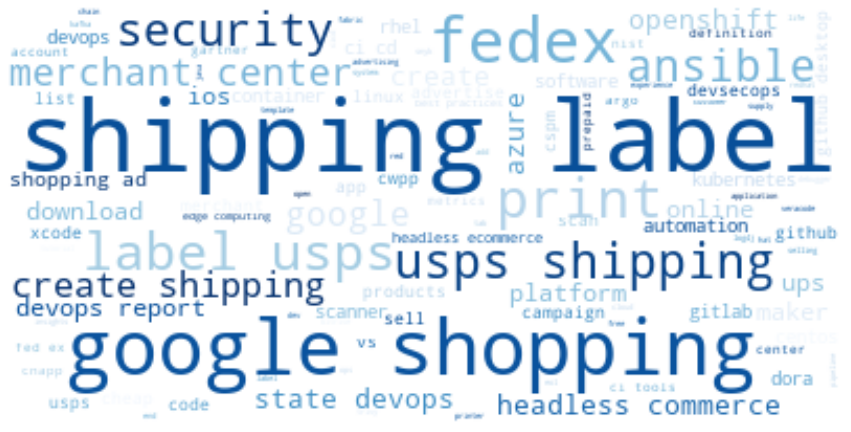

In [29]:
#normal wordcloud
#from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
word_cloud_text = " ".join(query for query in categories['queries'])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white", colormap="Blues").generate(word_cloud_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# #image mask wordcloud
# from os import path
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# mask = np.array(Image.open("googlelogo.jpg"))
# word_cloud_text = " ".join(query for query in categories['queries'])


# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white", mask=mask).generate(word_cloud_text)
# #plt.figure()

# image_colors = ImageColorGenerator(mask)
# plt.figure(figsize=[20,15])
# plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")

# #plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()